In [2]:
import cv2
import torch
import random
import pickle
import time

import numpy as np
import seaborn as sns
import torch.nn as nn
import torchvision.transforms as tf
import matplotlib.pyplot as plt
import torch.nn.functional as F

from PIL import Image
from torch.utils.data import Dataset, DataLoader

from glob import glob
from torchsummary import summary

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
# Local PC로 실습하는 경우 실행 x / 단 작업경로를 "LGES_240621"로 맞춰주기
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/LGES_240621

In [2]:
# 똑같은 결과를 얻기 위한 시드 고정
seed = 2024
torch.manual_seed(seed) # torch cpu seed 고정
torch.cuda.manual_seed(seed) # torch gpu seed 고정
torch.cuda.manual_seed_all(seed) # torch multi-gpu seed 고정
np.random.seed(seed) # numpy seed 고정
random.seed(seed) # python seed 고정

#### Heros Data Resnet18로 전이학습하기

Heros data : 6 종류의 히어로 이미지를 분류하는 데이터

각 클래스 별로 130장의 학습 데이터와 30여장의 테스트 데이터가 존재

학습 데이터는 (224,224)로 사이즈가 고정되어 있지만 테스트 데이터는 사이즈가 다름

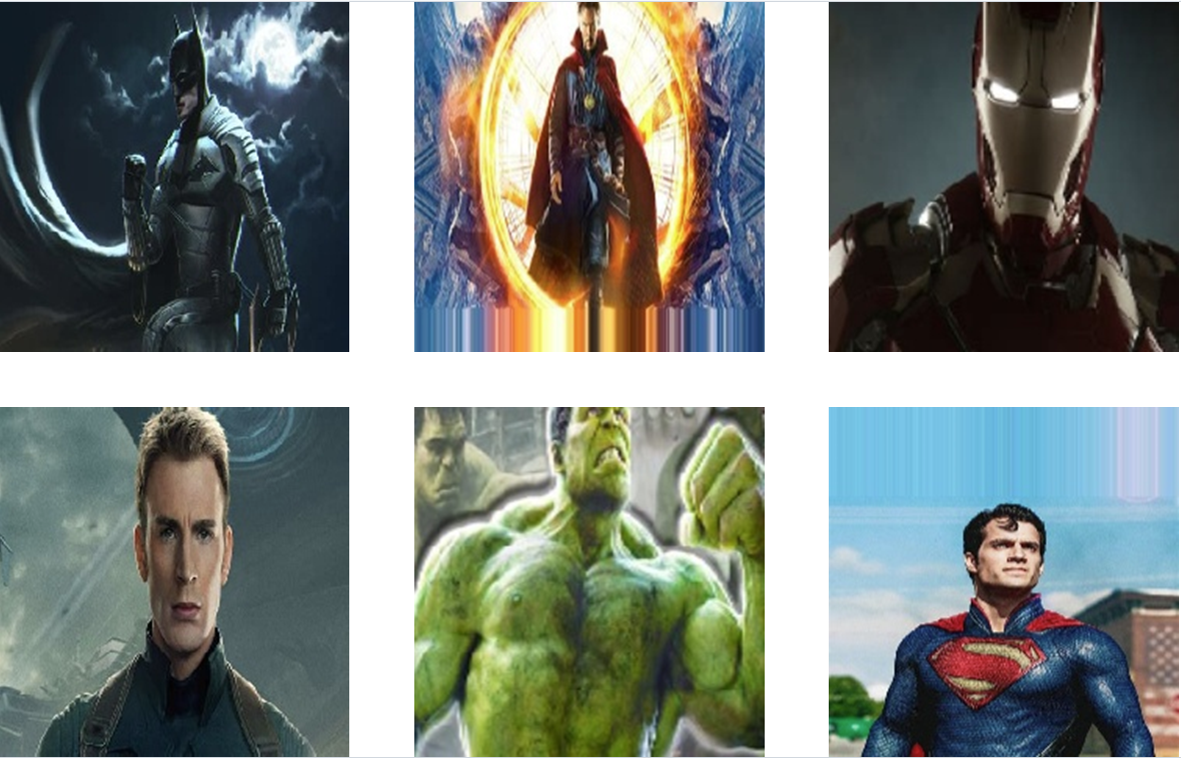

#### 데이터셋 & 데이터로더

학습 데이터에서 30%를 validation으로 활용


In [ ]:
"""
class CustomDataset(torch.utils.data.Dataset):
  def __init__(self):
  데이터셋을 불러오거나 입력받아 전처리를 해주는 부분

  def __len__(self):
  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분
  len을 통해서 getitem의 idx 범위가 결정

  def __getitem__(self, idx): 
  데이터셋에서 특정 1개의 샘플을 가져오는 함수
"""

In [5]:
import os
from PIL import Image
from glob import glob
import torchvision.transforms as tf
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class HeroDataset(Dataset):
    def __init__(self, mode):
        # for문을 활용해 여러 hero에 대한 이미지 경로 합치기
        hero_list = os.listdir('./data/heros/train')
        train_path, test_path = [], []
        train_labels, test_labels = [], []
        
        for label, hero in enumerate(hero_list): # 각 class 별로 data split 진행
            # enumerate함수는 반복이 진행된 횟수를 리턴(0부터 시작)
            
            # 현재 hero의 train 이미지 경로들을 glob함수로 불러오기
            crt_train_path = glob(f'./data/heros/train/{hero}/*')
            # i번째 hero의 class를 i로 지정
            crt_train_labels = [label] * len(crt_train_path)
        
            # 현재 hero의 test 이미지 경로들을 glob함수로 불러오기
            crt_test_path = glob(f'./data/heros/test/{hero}/*')
            # i번째 hero의 class를 i로 지정
            crt_test_labels = [label] * len(crt_test_path)
            
            # 전체 path에 저장
            train_path += crt_train_path
            test_path += crt_test_path
            
            # 전체 labels에 저장
            train_labels += crt_train_labels
            test_labels += crt_test_labels
        
        # train/valid split
        train_path, valid_path, train_labels, valid_labels = train_test_split(train_path, train_labels, test_size=0.3, random_state=2024)
        
        if mode == 'train':
            self.img_path = train_path
            self.labels = train_labels
            self.transform = tf.Compose([
                                      # tf.ToPILImage(), 만약 데이터가 array나 tensor로 되어 있는 경우 PILImage로 변경이 필요
                                      tf.RandAugment(num_ops=2, magnitude=9),
                                      tf.Resize(size=(128,128)),
                                      tf.ToTensor()
                                      # tf.Normalize(mean=(0.0,0.0,0.0), std=(1.,1.,1.)), RGB의 평균과 분산을 알고 있는 경우 정규화
                                                    ])
        elif mode == 'valid':
            self.img_path = valid_path
            self.labels = valid_labels
            self.transform = tf.Compose([
                                      tf.Resize(size=(128,128)),
                                      tf.ToTensor(),
                                      # tf.Normalize(mean=(0.0,0.0,0.0), std=(1.,1.,1.))
                                      ])
        else:
            self.img_path = test_path
            self.labels = test_labels
            self.transform = tf.Compose([
                                      tf.Resize(size=(128,128)),
                                      tf.ToTensor(),
                                      # tf.Normalize(mean=(0.0,0.0,0.0), std=(1.,1.,1.))
                                      ])
    
    def __len__(self):
          return len(self.img_path)
        
    def __getitem__(self,idx):
          crt_img_path = self.img_path[idx] # 특정 이미지의 경로 선택
          img = Image.open(crt_img_path) # 이미지 오픈
          X = self.transform(img) # 이미지 변형
          y = self.labels[idx]
      
          return X, y

In [6]:
# 학습/테스트 데이터셋 및 데이터로더 생성
batch_size = 64
trainset = HeroDataset(mode='train')

validset = HeroDataset(mode='valid')

testset = HeroDataset(mode='test')

trainloader = DataLoader(dataset=trainset, 
                         batch_size=batch_size,
                         shuffle=True,
                         drop_last=False)

validloader = DataLoader(dataset=validset, 
                         batch_size=batch_size,
                         shuffle=False,
                         drop_last=False)

testloader = DataLoader(dataset=testset, 
                         batch_size=batch_size,
                         shuffle=False,
                         drop_last=False)

print(f'trainset 이미지 수 : {len(trainset.img_path)}')
print(f'validset 이미지 수 : {len(validset.img_path)}')
print(f'testset 이미지 수  : {len(testset.img_path)}')

trainset 이미지 수 : 546
validset 이미지 수 : 234
testset 이미지 수  : 210


In [7]:
trainset.__getitem__(0)[0].shape

torch.Size([3, 128, 128])

#### Resnet18을 활용한 전이학습

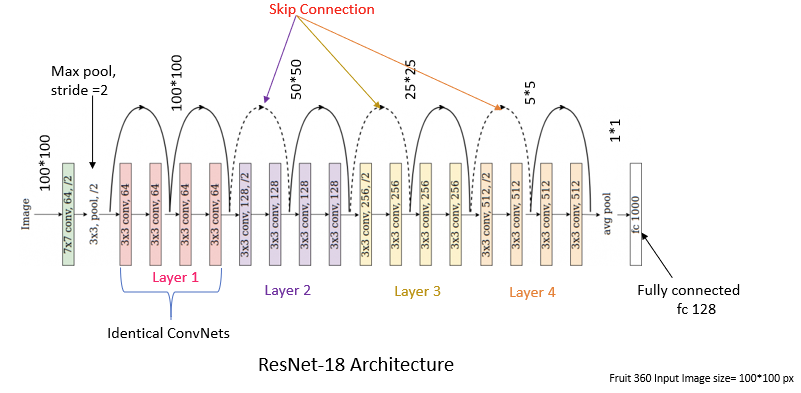

In [8]:
from torchvision.models import resnet18, ResNet18_Weights

# 사전 학습된 resnet18 가져오기
model = resnet18(weights=ResNet18_Weights.DEFAULT)
summary(model, input_size=(3,128,128), device='cpu')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\korea/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:04<00:00, 9.97MB/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

In [9]:
# 파라미터가 업데이트 되지 않도록 모든 레이어에 대해 required_grad 끄기
for param in model.parameters():
    param.requires_grad = False

In [10]:
# classifier를 현재 데이터의 클래스 개수에 맞게 대체(required_grad는 자동으로 켜짐)
# resnet에서는 .fc를 통해서 마지막 classifier에 접근 가능
num_classes = 6
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)
print(model.fc, next(model.fc.parameters()).requires_grad)

Linear(in_features=512, out_features=6, bias=True) True


#### optimizer 및 loss function 정의

In [11]:
lr = 0.001
weight_decay = 5e-4

optimizer = torch.optim.Adam(params=model.fc.parameters(),
                             lr=lr,
                             weight_decay=weight_decay)
loss_fn = nn.CrossEntropyLoss()

#### To device

In [13]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
    
# 모델 파라미터를 device로 이동
model.to(device)
# loss function을 device로 이동
loss_fn.to(device)

CrossEntropyLoss()

#### 역전파 알고리즘

In [14]:
# 한 에폭에 대한 학습 단계 함수화
def train(model,
          optimizer,
          loss_fn,
          dataloader,
          device):
    
    model.train() # set train mode
    
    # epoch마다 학습이 어떻게 진행되는지 추적하기 위한 변수
    train_loss = 0.0
    train_acc = 0.0
    n_train = 0
    
    for (imgs, targets) in dataloader: # loader를 통해 batch만큼 getitem
        
         # 두 텐서를 모델, 목적함수와 같은 device로
        imgs = imgs.to(device) # B,3,32,32
        targets = targets.to(device) # B
        
        # forward
        outputs = model(imgs) # B,2
        
        # loss 계산
        loss = loss_fn(outputs, targets)
        
        # optimizer gradient 초기화
        optimizer.zero_grad()
        
        # backward : gradient 계산
        loss.backward()
        
        # model weight update
        optimizer.step()
        
        # loss 저장
        train_loss += loss.item()
        
        # 맞게 예측한 개수 및 배치 데이터 개수 저장
        preds = torch.max(outputs.detach(), dim=-1)[1] # B
        acc = torch.eq(preds,targets).sum().cpu().item()
        train_acc += acc
        n_train += targets.shape[0]
    
    # 현재 에폭 평균 학습 loss와 accuracy 계산
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / n_train
    
    return train_loss, train_acc

In [15]:
 # 추론 단계 함수화
def test(model,
        loss_fn,
        dataloader,
        device):
    
    model.eval() # set eval mode
    
    test_loss = 0.0
    test_acc = 0.0
    n_test = 0
    
    with torch.no_grad():
        for (imgs, targets) in dataloader: # loader를 통해 batch만큼 getitem
            
            # 두 텐서를 모델, 목적함수와 같은 device로
            imgs = imgs.to(device) # B,3,32,32
            targets = targets.to(device) # B
            
            # forward
            outputs = model(imgs) # B,2
            
            # loss 계산
            loss = loss_fn(outputs, targets)
            
            # loss 저장
            test_loss += loss.item()
            
            # 맞게 예측한 개수 및 배치 데이터 개수 저장
            preds = torch.max(outputs.detach(), dim=-1)[1] # B
            acc = torch.eq(preds,targets).sum().cpu().item()
            test_acc += acc
            n_test += targets.shape[0]
    
    # 현재 에폭 평균 학습 loss와 accuracy 계산
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / n_test
    
    return test_loss, test_acc

In [16]:
# 전체적인 학습 프레임워크를 함수화
def main(model,
         trainloader,
         validloader,
         testloader,
         optimizer,
         loss_fn,
         epochs,
         save_name='cat_dog_lenet5'):
    
    # device 세팅
    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'
        
    # To device
    model.to(device)
    loss_fn.to(device)
    
    # training
    best_acc = 0.
    train_history = {'loss':[],'acc':[]}
    valid_history = {'loss':[],'acc':[]}
    
    print('-'*20, '학습 시작', '-'*20)
    print(f'Experiment : {save_name} \n')
    
    elapsed_time = time.time()
    for epoch in range(epochs):
        epoch_time = time.time()
        # 한 에폭에 대한 학습
        train_loss, train_acc = train(model=model,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      dataloader=trainloader,
                                      device=device)
        # 에폭마다 validset을 통한 모델 평가
        valid_loss, valid_acc = test(model=model,
                                      loss_fn=loss_fn,
                                      dataloader=validloader,
                                      device=device)
        
        # best model일 경우 모델 저장
        if valid_acc > best_acc:
            best_acc = valid_acc
            best_epoch = epoch+1
            save_dict = {'model':model.state_dict(),
                        'optimizer':optimizer.state_dict(),
                        'epoch':best_epoch,
                        'acc':best_acc}
            torch.save(save_dict, f'./results/{save_name}.pt')
    
        # 학습/테스트에 소요된 시간 계산
        epoch_time = time.time() - epoch_time
        
        # 학습 정보 출력
        print(f'Epoch     : {epoch+1:6} | Time     : {epoch_time:.2f} sec')
        print(f'Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f}')
        print(f'Train ACC : {train_acc:.4f} | Valid ACC : {valid_acc:.4f} \n')
    
        # 에폭별 학습 정보 저장
        train_history['loss'].append(train_loss)
        train_history['acc'].append(train_acc)
        valid_history['loss'].append(valid_loss)
        valid_history['acc'].append(valid_acc)

    print('-'*20, '학습 종료', '-'*20)
    print(f'Best ACC : {best_acc:.4f} | Best Epoch : {best_epoch} \n')
    
    print('-'*20, '테스트', '-'*20)
    # load best model
    load_dict = torch.load(f'./results/{save_name}.pt', map_location=device)
    parameters = load_dict['model'] 
    model.load_state_dict(parameters, strict=False)
    
    test_loss, test_acc = test(model=model,
                                loss_fn=loss_fn,
                                dataloader=testloader,
                                device=device)
    
    elapsed_time = time.time() - elapsed_time
    
    print(f'Experiments : {save_name}')
    print(f'test Loss   : {test_loss:.4f} \n')
    print(f'test ACC    : {test_acc:.4f} \n')
    print(f'Total Time  : {elapsed_time:.4f} \n')
    
    return train_history, valid_history

In [17]:
epochs = 30
train_history, valid_history = main(model=model,
                                   trainloader=trainloader,
                                   validloader=validloader,
                                   testloader=testloader,
                                   optimizer=optimizer,
                                   loss_fn=loss_fn,
                                   epochs=epochs,
                                   save_name='heros_resnet18')

-------------------- 학습 시작 --------------------
Experiment : heros_resnet18 

Epoch     :      1 | Time     : 5.06 sec
Train Loss: 1.8386 | Valid Loss: 1.8541
Train ACC : 0.1996 | Valid ACC : 0.2607 

Epoch     :      2 | Time     : 0.93 sec
Train Loss: 1.6794 | Valid Loss: 1.6205
Train ACC : 0.3278 | Valid ACC : 0.3632 

Epoch     :      3 | Time     : 0.96 sec
Train Loss: 1.4721 | Valid Loss: 1.4719
Train ACC : 0.4212 | Valid ACC : 0.4103 

Epoch     :      4 | Time     : 1.00 sec
Train Loss: 1.3502 | Valid Loss: 1.2634
Train ACC : 0.5238 | Valid ACC : 0.5855 

Epoch     :      5 | Time     : 1.11 sec
Train Loss: 1.2147 | Valid Loss: 1.1200
Train ACC : 0.5897 | Valid ACC : 0.6496 

Epoch     :      6 | Time     : 1.27 sec
Train Loss: 1.0885 | Valid Loss: 1.0363
Train ACC : 0.6264 | Valid ACC : 0.6795 

Epoch     :      7 | Time     : 1.25 sec
Train Loss: 1.0138 | Valid Loss: 0.9514
Train ACC : 0.6685 | Valid ACC : 0.6880 

Epoch     :      8 | Time     : 1.44 sec
Train Loss: 0.9417 |

#### 학습 과정 시각화

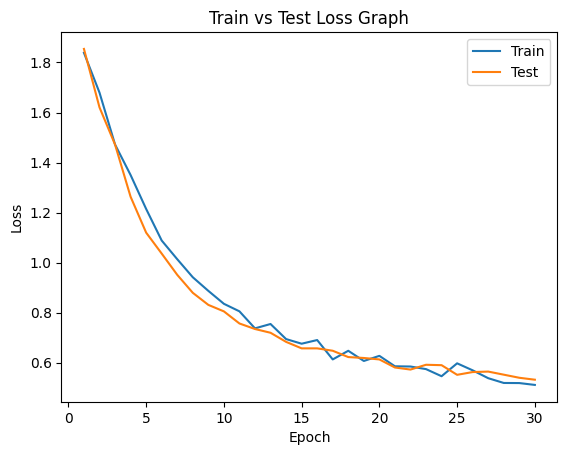

In [18]:
sns.lineplot(x=range(1,epochs+1),y=train_history['loss'], label='Train')
sns.lineplot(x=range(1,epochs+1),y=valid_history['loss'], label='Test')
plt.title('Train vs Test Loss Graph')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

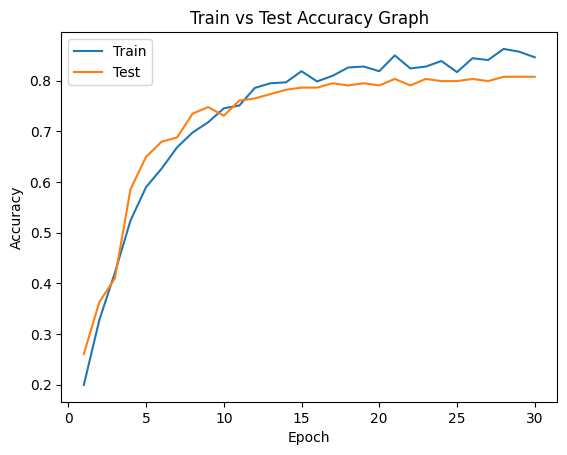

In [19]:
sns.lineplot(x=range(1,epochs+1),y=train_history['acc'], label='Train')
sns.lineplot(x=range(1,epochs+1),y=valid_history['acc'], label='Test')
plt.title('Train vs Test Accuracy Graph')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#### CAM을 통한 해석

resnet은 마지막에 GAP를 사용하기 때문에 따로 classifier를 수정하지 않아도 됨

하지만 feature를 뽑아야 계산이 가능하기 때문에 get_activation 함수를 만들어야 함

resnet forward 구조 : https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py

In [20]:
# cam을 위한 resnet 모델
class resnet18_cam(nn.Module):
    def __init__(self):
        super(resnet18_cam, self).__init__()
        
        # Resnet 모델을 정의하고 catdog으로 학습시킨 파라미터 불러오기
        base = resnet18(weights=None)

        base.fc = nn.Linear(in_features, 6)
        parameters = torch.load('./results/heros_resnet18.pt')['model']
        base.load_state_dict(parameters)
        
        # feature extractor / resnet forward 구조 확인
        self.feature_extractor = nn.Sequential(base.conv1,
                                               base.bn1,
                                               base.relu,
                                               base.maxpool,
                                               base.layer1,
                                               base.layer2,
                                               base.layer3,
                                               base.layer4)
        
        # classifier / resnet forward 구조 확인
        self.fc = nn.Sequential(base.avgpool, nn.Flatten(), base.fc)
        
    def forward(self, x):
        # B, 3, 128, 128
        x = self.feature_extractor(x)
        x = self.fc(x)
        return x
    
    def get_activations(self, x):
        return self.feature_extractor(x)
    
resnet_cam = resnet18_cam()
resnet_cam.eval()

summary(resnet_cam, input_size=(3,128,128), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

In [21]:
def return_CAM(feature_conv, weight, class_idx):
    # feats : N, 512, 8, 8
    # weight : C, 512
    # generate the class -activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        beforeDot =  feature_conv.reshape((nc, h*w))
        cam = np.matmul(weight[idx], beforeDot) # 해당 class에 대한 weight에 featuremap 곱하기
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam) # minmax-saleing
        cam_img = cam / np.max(cam) # minmax-saleing
        cam_img = np.uint8(255 * cam_img)  # 0~255로 scale 변환
        output_cam.append(cv2.resize(cam_img, size_upsample))
        
    return output_cam

torch.Size([1, 3, 128, 128])


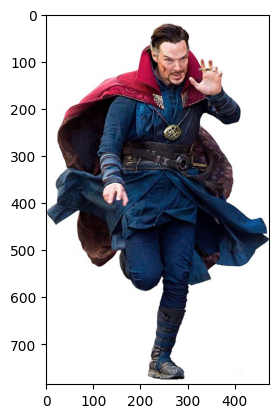

In [22]:
# test image
import torchvision.transforms as tf
img_path = './data/heros/test/Dr Strange/5.jpg'
test_img = Image.open(img_path)
plt.imshow(test_img)

preprocess = tf.Compose([
   tf.Resize((128,128)),
   tf.ToTensor()
])

test_img = preprocess(test_img)
test_img = test_img.unsqueeze(0) # 1, 3, 128, 128
print(test_img.shape)

In [23]:
out = resnet_cam(test_img)
feat = resnet_cam.get_activations(test_img)
print(out.shape, feat.shape)

torch.Size([1, 6]) torch.Size([1, 512, 4, 4])


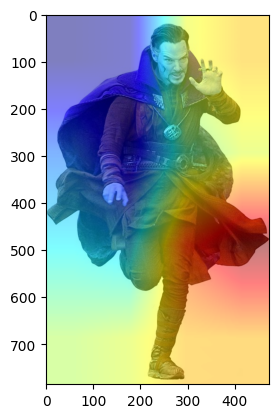

In [24]:
# Softmax 함수를 적용하여 확률값 구하기
h_x = F.softmax(out, dim=1).data.squeeze()
probs, idx = h_x.sort(0, True)
probs = probs.detach().numpy()
idx = idx.numpy()

# las conv layer feature
feat_numpy = feat.cpu().detach().numpy()

params = list(resnet_cam.fc.parameters()) # params[0] : weight, params[1] : bias
weight = np.squeeze(params[0].data.numpy())

# Class Activation Map
CAMs = return_CAM(feat_numpy, weight, [idx[0]])

# CAM 결과 히트맵 시각화 & 저장
img = cv2.imread(img_path) # numpy로 load : H,W,3
height, width, _ = img.shape
heatmap = cv2.applyColorMap(cv2.resize(CAMs[0], (width, height)), cv2.COLORMAP_JET)
result = heatmap * 0.5 + img * 0.5

cv2.imwrite('./results/CAM_result_Dr strange.png', result)
plt.imshow(result/255.)
